# Airline Ticket Sales Simulations
**Brett Bartol**

**Import Packages**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from scipy.stats import binom

**Declare Necessary Variables**

In [2]:
T = 365 # num days

fc_num = 20 # number of first class seats

fc_h = 500 # first class high price
fc_hp = .04 # first class high sale prob 
fc_l = 425 # first class low price
fc_lp = .08 # first class low sale prob 
fc_show = .97 # fisrt class show up prob

c_num = 100 # number of coach seats

c_h = 350 # coach high price
c_hp = .3 # coach high sale probability 
c_l = 300 # coach low price
c_lp = .65 # coach low sale prob
c_show = .95 # coach show up prob

d = 1 / (1 + .15 / 365) # daily discount rate

fc_upgrade = 50 # cost to move someone from coach to first class
c_bump = 425 # cost to bump a coach pasenger off plane

**Create Function to Build Value and Option Matrix**

In [16]:
def get_expected_earnings(num_coach_oversell, coach_option = False):
    
    oversell = num_coach_oversell
    
    tValues = np.arange(T + 1) # array of all possible days
    cValues = np.arange(c_num + oversell + 1) # array of all possible number of coach seats sold
    fcValues = np.arange(fc_num + 1) # array of all possible number of first class seats sold

    # sizes of three arrays above
    tN = len(tValues) 
    cN = len(cValues)
    fcN = len(fcValues)
    
    V = np.zeros((tN, cN, fcN)) # value matrix
    U = np.zeros((tN, cN, fcN)) # option matrix
    
    # terminal values
    for c in range(cN):
        for f in range(fcN):
            for i in range(c + 1):
                for j in range(f + 1):
                    
                    if i < c_num:
                        V[T, c, f] += 0 # no overbookings
                    
                    else:
                        overbooked = i - c_num # calc overbookings
                        upgraded = fc_num - j # find number upgraded
                        if upgraded < overbooked:
                            upgrade = upgraded # get number upgraded
                            off = overbooked - upgrade # calc number of people kicked off flight
                        else:
                            upgrade = overbooked
                            off = 0
                        
                        # add expected value
                        V[T, c, f] += - ((fc_upgrade * upgrade + c_bump * off)) * binom.pmf(i, c, c_show) * binom.pmf(j, f, fc_show)
                U[T, c, f] = 8 # set no seats sold on the last day
    
    for ti in reversed(range(tN - 1)): # loop backwards through all days
        for ci in range(cN): # loop through all possible numbers of coach tickets
            for fci in range(fcN): # loop through all possible numbers of first class tickets
            
                t = tValues[ti] # day value 
                c = cValues[ci] # coach seats value
                fc = fcValues[fci] # first class seats value
            
                valueChoices = np.array([-np.inf] * 9) # LL, HL, LH, HH, L_, H_, _L, _H, __
            
                if c >= (c_num + oversell) and fc >= fc_num: # done selling tickets
                
                    valueChoices[8] = d * V[t + 1, c, fc]
            
                elif c >= (c_num + oversell): # done selling coach tickets
                
                    # selling first class at low price
                    valueChoices[6] = fc_l * fc_lp + d * (V[t + 1, c, fc] * (1 - fc_lp) +
                                                                   V[t + 1, c, fc + 1] * fc_lp)
               
                    
                    # selling first class at high price
                    valueChoices[7] = fc_h * fc_hp + d * (V[t + 1, c, fc] * (1 - (fc_hp)) +
                                                                   V[t + 1, c, fc + 1] * (fc_hp))
           
                elif fc >= fc_num: # done selling first class tickets
            
                    # selling coach at low price    
                    valueChoices[4] = c_l * c_lp + d * (V[t + 1, c, fc] * (1 - (c_lp)) +
                                                                   V[t + 1, c + 1, fc] * (c_lp))
                    
                    # selling coach at high price
                    valueChoices[5] = c_h * c_hp + d * (V[t + 1, c, fc] * (1 - (c_hp)) +
                                                                   V[t + 1, c + 1, fc] * (c_hp))
                    
                    if coach_option: # only if coach option is true
                        
                        # selling no tickets
                        valueChoices[8] = d * V[t + 1, c, fc]
            
                else: # selling all tickets       
            
                    # selling coach at low price and first class at low price
                    valueChoices[0] = fc_l * fc_lp + c_l * c_lp + d * (V[t + 1, c, fc] * (1 - c_lp) * (1 - fc_lp)  +
                                                                   V[t + 1, c + 1, fc] * (1 - fc_lp) * c_lp +
                                                                   V[t + 1, c, fc + 1] * (1 - c_lp) * fc_lp +
                                                                   V[t + 1, c + 1, fc + 1] * c_lp * fc_lp)

                    # selling coach at high price and first class at low price
                    valueChoices[1] = fc_l * fc_lp + c_h * c_hp + d * (V[t + 1, c, fc] * (1 - (c_hp)) * (1 - (fc_lp)) +
                                                                   V[t + 1, c + 1, fc] * (1 - fc_lp) * c_hp +
                                                                   V[t + 1, c, fc + 1] * (1 - c_hp) * fc_lp +
                                                                   V[t + 1, c + 1, fc + 1] * c_hp * fc_lp)

                    # selling coach at low price and first class at high price
                    valueChoices[2] = fc_h * fc_hp + c_l * c_lp + d * (V[t + 1, c, fc] * (1 - c_lp) * (1 - fc_hp) +
                                                                   V[t + 1, c + 1, fc] * (1 - fc_hp) * c_lp +
                                                                   V[t + 1, c, fc + 1] * (1 - c_lp) * fc_hp +
                                                                   V[t + 1, c + 1, fc + 1] * c_lp * fc_hp)

                    # selling coach at high price and first class at high price
                    valueChoices[3] = fc_h * fc_hp + c_h * c_hp + d * (V[t + 1, c, fc] * (1 - c_hp) * (1 - fc_hp) +
                                                                   V[t + 1, c + 1, fc] * (1 - fc_hp) * c_hp +
                                                                   V[t + 1, c, fc + 1] * (1 - c_hp) * fc_hp +
                                                                   V[t + 1, c + 1, fc + 1] * c_hp * fc_hp)
                    
                    if coach_option: # only if coach option is true
                        
                        # selling first class at low price
                        valueChoices[6] = fc_l * fc_lp + d * (V[t + 1, c, fc] * (1 - (fc_lp)) +
                                                                   V[t + 1, c, fc + 1] * (fc_lp))
                    
                        # selling first class at high price
                        valueChoices[7] = fc_h * fc_hp + d * (V[t + 1, c, fc] * (1 - (fc_hp)) +
                                                                   V[t + 1, c, fc + 1] * (fc_hp))

                V[ti, ci, fci] = np.max(valueChoices) # pick the one that maximizes that value
                U[ti, ci, fci] = np.argmax(valueChoices) # find option that is chosen
    
    return U, V  

**Part 1**

In [10]:
oversell = 5

U, V = get_expected_earnings(oversell) # get u and v matrices

print('Expected Profit:', V[0, 0, 0]) # expected profit at day 0

Expected Profit: 42242.86219879489


*Sample Simulation*

In [11]:
coach = 0
first_class = 0

options = ['First Class Low Price, Coach Low Price', 'First Class Low Price, Coach High Price',
          'First Class High Price, Coach Low Price', 'First Class High Price, Coach High Price', 
          'Coach Low Price', 'Coach High Price', 'First Class Low Price', 'First Class High Price', 'Not Selling']

fc_perc = [fc_lp, fc_lp, fc_hp, fc_hp, 0, 0, fc_hp, fc_lp, 0]
c_perc = [c_lp, c_hp, c_lp, c_hp, c_lp, c_hp, 0, 0, 0]

    
c = coach
fc = first_class

for t in range(T + 1):
    
    print("Day: ", t, " Coach Seats Sold: ", c, " First Class Seats Sold: ", fc, " Todays Pricing: ", options[int(U[t, c, fc])], sep='')
    
    if random.random() <= fc_perc[int(U[t, c, fc])] and fc < fc_num:
        
        fc += 1
        
    if random.random() <= c_perc[int(U[t, c, fc])] and c < c_num + oversell:
        
        c += 1  

Day: 0 Coach Seats Sold: 0 First Class Seats Sold: 0 Todays Pricing: First Class Low Price, Coach High Price
Day: 1 Coach Seats Sold: 0 First Class Seats Sold: 0 Todays Pricing: First Class Low Price, Coach High Price
Day: 2 Coach Seats Sold: 0 First Class Seats Sold: 0 Todays Pricing: First Class Low Price, Coach High Price
Day: 3 Coach Seats Sold: 1 First Class Seats Sold: 0 Todays Pricing: First Class Low Price, Coach High Price
Day: 4 Coach Seats Sold: 2 First Class Seats Sold: 0 Todays Pricing: First Class Low Price, Coach High Price
Day: 5 Coach Seats Sold: 3 First Class Seats Sold: 0 Todays Pricing: First Class Low Price, Coach High Price
Day: 6 Coach Seats Sold: 4 First Class Seats Sold: 0 Todays Pricing: First Class Low Price, Coach High Price
Day: 7 Coach Seats Sold: 4 First Class Seats Sold: 0 Todays Pricing: First Class Low Price, Coach High Price
Day: 8 Coach Seats Sold: 5 First Class Seats Sold: 0 Todays Pricing: First Class Low Price, Coach High Price
Day: 9 Coach Seats 

Day: 202 Coach Seats Sold: 77 First Class Seats Sold: 12 Todays Pricing: First Class High Price, Coach High Price
Day: 203 Coach Seats Sold: 78 First Class Seats Sold: 12 Todays Pricing: First Class High Price, Coach High Price
Day: 204 Coach Seats Sold: 78 First Class Seats Sold: 13 Todays Pricing: First Class High Price, Coach High Price
Day: 205 Coach Seats Sold: 78 First Class Seats Sold: 13 Todays Pricing: First Class High Price, Coach High Price
Day: 206 Coach Seats Sold: 78 First Class Seats Sold: 13 Todays Pricing: First Class High Price, Coach High Price
Day: 207 Coach Seats Sold: 78 First Class Seats Sold: 13 Todays Pricing: First Class High Price, Coach High Price
Day: 208 Coach Seats Sold: 78 First Class Seats Sold: 13 Todays Pricing: First Class High Price, Coach High Price
Day: 209 Coach Seats Sold: 78 First Class Seats Sold: 13 Todays Pricing: First Class High Price, Coach High Price
Day: 210 Coach Seats Sold: 79 First Class Seats Sold: 13 Todays Pricing: First Class Hig

**Part 2**

In [12]:
expected_earnings = []
for i in tqdm(range(6, 16)): # loop through 6 - 15
    U, V = get_expected_earnings(i, False) # plug each overselling point into the function
    expected_earnings.append(V[0, 0, 0]) # get expected value at day 0

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [05:02<00:00, 30.27s/it]


Text(0.5, 0, '# of Coach Seats Oversold')

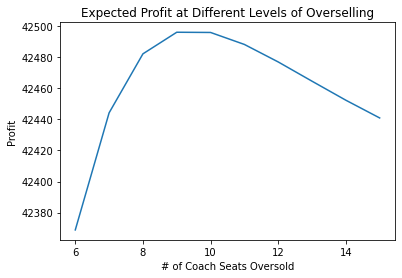

In [13]:
plt.plot(range(6, 16), expected_earnings) # plot earnings at each level of overselling
plt.title('Expected Profit at Different Levels of Overselling')
plt.ylabel('Profit')
plt.xlabel('# of Coach Seats Oversold')

In [30]:
print('Optimal Oversell:', range(6, 16)[np.array(expected_earnings).argmax()])

Optimal Oversell: 9


In [61]:
max(expected_earnings)

42496.11230437854

**Part 3**

In [15]:
U, V = get_expected_earnings(20, True) # plug each overselling point into the function
print('Expected Profit with Option to Not Sell Coach:', V[0, 0, 0]) # get expected value at day 0

Expected Profit with Option to Not Sell Coach: 42502.673261243624


**Part 4**

In [17]:
# all possible selling options (stored in U matrix)
options = ['First Class Low Price, Coach Low Price', 'First Class Low Price, Coach High Price',
          'First Class High Price, Coach Low Price', 'First Class High Price, Coach High Price', 
          'Coach Low Price', 'Coach High Price', 'First Class Low Price', 'First Class High Price', 'Not Selling']

fc_perc = [fc_lp, fc_lp, fc_hp, fc_hp, 0, 0, fc_hp, fc_lp, 0] # first class probabilities
c_perc = [c_lp, c_hp, c_lp, c_hp, c_lp, c_hp, 0, 0, 0] # coach probabilities

fc_price = [fc_l, fc_l, fc_h, fc_h, 0, 0, fc_h, fc_l, 0] # first class prices
c_price = [c_l, c_h, c_l, c_h, c_l, c_h, 0, 0, 0] # coach prices

*Simulation Always Selling Coach tickets*

In [38]:
# run sims always selling coach tickets
optimal_overbooking = range(6, 16)[np.array(expected_earnings).argmax()] # find level with highest earnings

U, V = get_expected_earnings(optimal_overbooking, False) # get necessary matrices

n_sims = 10000 # number of simulations

earnings = np.zeros(n_sims)
end_costs = np.zeros(n_sims)
is_overbooked = np.zeros(n_sims)
passenger_kickoff = np.zeros(n_sims)
num_coach = np.zeros(n_sims)

coach_seats_daily = np.zeros((n_sims, T))
fc_seats_daily = np.zeros((n_sims, T))
earnings_daily = np.zeros((n_sims, T + 1))


for sim in tqdm(range(n_sims)):
    
    sim_earnings = 0
    
    c = 0 # start with 0 coach tickets sold
    fc = 0 # start with 0 first class tickets sold
    
    for t in range(T):

    
        #print("Day: ", t, " Coach Seats Sold: ", c, " First Class Seats Sold: ", fc, " Todays Pricing: ", options[int(U[t, c, fc])], sep='')
    
        if random.random() <= fc_perc[int(U[t, c, fc])] and fc < fc_num and int(U[t, c, fc]) not in [4, 5, 8]:
        
            fc += 1
            sim_earnings += fc_price[int(U[t, c, fc])] * d ** t
        
        if random.random() <= c_perc[int(U[t, c, fc])] and c < c_num + optimal_overbooking and int(U[t, c, fc]) not in [6, 7, 8]:
        
            c += 1 
            sim_earnings += c_price[int(U[t, c, fc])] * d ** t
    
        coach_seats_daily[sim, t] = c
        fc_seats_daily[sim, t] = fc
        earnings_daily[sim, t] = sim_earnings
    
    coach_show_up = 0
    for i in range(c):
        if random.random() < c_show:
            coach_show_up += 1
    
    fc_show_up = 0
    for i in range(fc):
        if random.random() < fc_show:
            fc_show_up += 1
    
    exp_cost = 0 # end costs that we will add to
            
    if coach_show_up > c_num: # make sure we oversold the plane
                
        exp_upgrade = 0 # number of people upgraded to first class
                
        if fc_show_up < fc_num: # check to see if there are empty spots in first class
                    
            exp_upgrade = min(fc_num - fc_show_up, coach_show_up - c_num) # number of people to be upgraded
            exp_cost += fc_upgrade * exp_upgrade # add the costs for upgrades
                
        exp_bumped = coach_show_up - exp_upgrade - c_num # number of people kicked off plane
                
        if exp_bumped > 0: # make sure number kicked off is above zero
            exp_cost += c_bump * exp_bumped # add costs for kicking people off the plane
    
    sim_earnings -= exp_cost * d ** T
    earnings_daily[sim, T] = sim_earnings
    
    earnings[sim] = sim_earnings
    end_costs[sim] = V[T, c, fc]
    is_overbooked[sim] = True if (coach_show_up) > (c_num) else False
    passenger_kickoff[sim] = True if (coach_show_up - c_num) > (fc_num - fc_show_up) else False
    num_coach[sim] = c

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:14<00:00, 676.66it/s]


In [39]:
print('Mean Profit:', np.mean(earnings), 'STD of Profit:', np.std(earnings))

Mean Profit: 42522.16947918581 STD of Profit: 755.914997060433


In [40]:
print('Mean Costs:', np.mean(end_costs), 'STD of Costs:', np.std(end_costs))

Mean Costs: -933.1470487979209 STD of Costs: 367.02630483830546


In [41]:
print('Percent of Flights Overbooked:', np.mean(is_overbooked) * 100)

Percent of Flights Overbooked: 81.75


In [42]:
print('Percent of Flights with Passengers Kicked Off:', np.mean(passenger_kickoff) * 100)

Percent of Flights with Passengers Kicked Off: 67.24


In [43]:
print('Average Number of Coach Tickets Sold:', np.mean(num_coach), 'STD of Coach Tickets Sold:', np.std(num_coach))

Average Number of Coach Tickets Sold: 108.1717 STD of Coach Tickets Sold: 1.1344686465478013


Text(0.5, 1.0, 'Number of Coach Seats Sold')

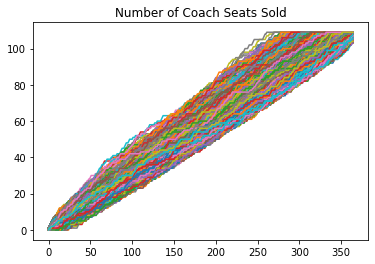

In [44]:
for x in range(n_sims):
    plt.plot(range(T), coach_seats_daily[x, :])
plt.title('Number of Coach Seats Sold')    

Text(0.5, 1.0, 'Number of First Class Seats Sold')

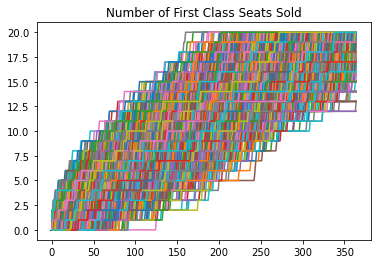

In [45]:
for x in range(n_sims):
    plt.plot(range(T), fc_seats_daily[x, :])
plt.title('Number of First Class Seats Sold')

Text(0.5, 1.0, 'Value at Each Day')

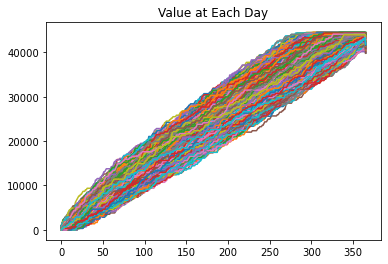

In [48]:
for x in range(n_sims):
    plt.plot(range(T + 1), earnings_daily[x, :])
plt.title('Value at Each Day')

*Simulation with the Option to Not Sell Coach Tickets*

In [49]:
# run sims with option to not sell coach tickets
optimal_overbooking = 20

U, V = get_expected_earnings(optimal_overbooking, True)

n_sims = 10000

earnings = np.zeros(n_sims)
end_costs = np.zeros(n_sims)
is_overbooked = np.zeros(n_sims)
passenger_kickoff = np.zeros(n_sims)
num_coach = np.zeros(n_sims)

coach_seats_daily = np.zeros((n_sims, T))
fc_seats_daily = np.zeros((n_sims, T))
earnings_daily = np.zeros((n_sims, T + 1))


for sim in tqdm(range(n_sims)):
    
    sim_earnings = 0
    
    c = 0 # start with 0 coach tickets sold
    fc = 0 # start with 0 first class tickets sold
    
    for t in range(T):

    
        #print("Day: ", t, " Coach Seats Sold: ", c, " First Class Seats Sold: ", fc, " Todays Pricing: ", options[int(U[t, c, fc])], sep='')
    
        if random.random() <= fc_perc[int(U[t, c, fc])] and fc < fc_num and int(U[t, c, fc]) not in [4, 5, 8]:
        
            fc += 1
            sim_earnings += fc_price[int(U[t, c, fc])] * d ** t
        
        if random.random() <= c_perc[int(U[t, c, fc])] and c < c_num + optimal_overbooking and int(U[t, c, fc]) not in [6, 7, 8]:
        
            c += 1 
            sim_earnings += c_price[int(U[t, c, fc])] * d ** t
    
        coach_seats_daily[sim, t] = c
        fc_seats_daily[sim, t] = fc
        earnings_daily[sim, t] = sim_earnings
    
    coach_show_up = 0
    for i in range(c):
        if random.random() < c_show:
            coach_show_up += 1
    
    fc_show_up = 0
    for i in range(fc):
        if random.random() < fc_show:
            fc_show_up += 1
    
    exp_cost = 0 # end costs that we will add to
            
    if coach_show_up > c_num: # make sure we oversold the plane
                
        exp_upgrade = 0 # number of people upgraded to first class
                
        if fc_show_up < fc_num: # check to see if there are empty spots in first class
                    
            exp_upgrade = min(fc_num - fc_show_up, coach_show_up - c_num) # number of people to be upgraded
            exp_cost += fc_upgrade * exp_upgrade # add the costs for upgrades
                
        exp_bumped = coach_show_up - exp_upgrade - c_num # number of people kicked off plane
                
        if exp_bumped > 0: # make sure number kicked off is above zero
            exp_cost += c_bump * exp_bumped # add costs for kicking people off the plane
    
    sim_earnings -= exp_cost * d ** T
    earnings_daily[sim, T] = sim_earnings
    
    earnings[sim] = sim_earnings
    end_costs[sim] = V[T, c, fc]
    is_overbooked[sim] = True if (coach_show_up) > (c_num) else False
    passenger_kickoff[sim] = True if (coach_show_up - c_num) > (fc_num - fc_show_up) else False
    num_coach[sim] = c

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:15<00:00, 643.11it/s]


In [50]:
print('Mean Profit:', np.mean(earnings), 'STD of Profit:', np.std(earnings))

Mean Profit: 42499.07971752719 STD of Profit: 770.564067068255


In [51]:
print('Mean Costs:', np.mean(end_costs), 'STD of Costs:', np.std(end_costs))

Mean Costs: -1002.2357115128625 STD of Costs: 366.90120389520115


In [52]:
print('Percent of Flights Overbooked:', np.mean(is_overbooked) * 100)

Percent of Flights Overbooked: 83.39


In [53]:
print('Percent of Flights with Passengers Kicked Off:', np.mean(passenger_kickoff) * 100)

Percent of Flights with Passengers Kicked Off: 70.77


In [54]:
print('Average Number of Coach Tickets Sold:', np.mean(num_coach), 'STD of Coach Tickets Sold:', np.std(num_coach))

Average Number of Coach Tickets Sold: 108.4261 STD of Coach Tickets Sold: 1.4465610218722196


Text(0.5, 1.0, 'Number of Coach Seats Sold')

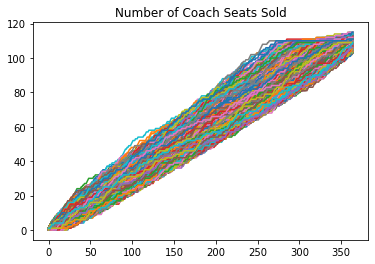

In [55]:
for x in range(n_sims):
    plt.plot(range(T), coach_seats_daily[x, :])
plt.title('Number of Coach Seats Sold')    

Text(0.5, 1.0, 'Number of First Class Seats Sold')

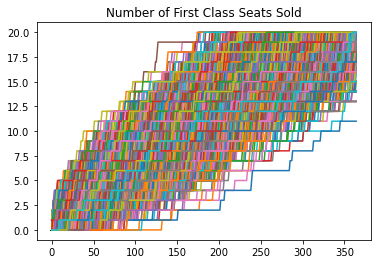

In [56]:
for x in range(n_sims):
    plt.plot(range(T), fc_seats_daily[x, :])
plt.title('Number of First Class Seats Sold')

Text(0.5, 1.0, 'Value at Each Day')

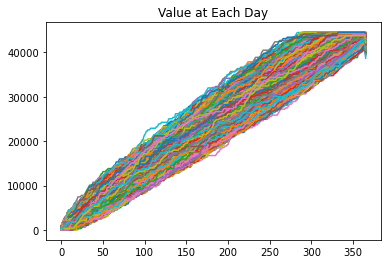

In [57]:
for x in range(n_sims):
    plt.plot(range(T + 1), earnings_daily[x, :])
plt.title('Value at Each Day')